In [1]:
import YOLO_V3.config as config
import torch
import torch.optim as optim
import os
from YOLO_V3.model import YOLOv3
from tqdm import tqdm
from YOLO_V3.yolo_v3_utils.utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from YOLO_V3.yolo_v3_utils.loss import YoloLoss
from YOLO_V3.PL_model import LitYOLOv3
from YOLO_V3.yolo_v3_utils.PL_data_module import YOLODataModule
from YOLO_V3.PL_main import train_yolov3_model
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Check the dataset path; I am using Local GPU hence, it should be pointing to a location 
print(config.DATASET)


C:\Users\rohit\Downloads\ERA_V1\session_13\PASCAL_VOC


**Define Data Module**

In [4]:
# Define data module
#csv_files = [os.path.join(config.DATASET, "100examples.csv"),os.path.join(config.DATASET,"8examples.csv")]
csv_files = [os.path.join(config.DATASET, "train.csv"),os.path.join(config.DATASET,"test.csv")]
train_transforms=config.train_transforms
test_transforms=config.test_transforms
val_transforms = test_transforms
IMAGE_SIZE = config.IMAGE_SIZE
S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
img_dir=config.IMG_DIR
label_dir=config.LABEL_DIR
anchors=config.ANCHORS
batch_size = 16
yolo_datamodule = YOLODataModule(
    csv_files,
    img_dir,
    label_dir,
    anchors,
    batch_size,
    image_size=IMAGE_SIZE,
    S=S,
    C=20,
    train_transforms = train_transforms,
    val_transforms = val_transforms,
    test_transforms = test_transforms,
    val_split=0.1,
    num_workers = config.NUM_WORKERS,
    use_mosaic_on_train=True,
    mosaic_probability=0.75,
    pin_memory = False)
yolo_datamodule.prepare_data()
yolo_datamodule.setup()

**Identify best LR**

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.91E-04


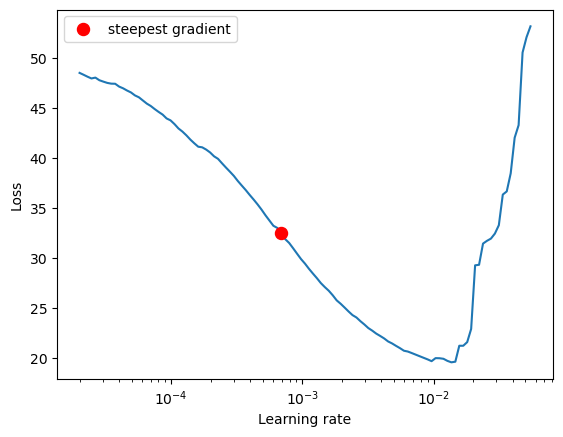

In [6]:
from torch_lr_finder import LRFinder
# Define model parameters
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)
loss_fn = YoloLoss()
conf_threshold = config.CONF_THRESHOLD
EPOCHS = config.NUM_EPOCHS * 2 // 5

# Define Model
yolo_model_for_lr = LitYOLOv3(loss_fn, scaled_anchors,conf_threshold, optimizer=None, scheduler_dict=None, num_classes=20, epochs=EPOCHS)
optimizer = optim.Adam(yolo_model_for_lr.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
train_data_loader = yolo_datamodule.train_dataloader()


def criterion(out, y):
    y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )
    loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )
    return loss
lr_finder = LRFinder(yolo_model_for_lr, optimizer, criterion, device="cuda")
lr_finder.range_test(train_data_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [7]:
max_lr = 8.91E-02

**Train model**

In [10]:
from YOLO_V3.PL_main import train_yolov3_model
from torch.optim.lr_scheduler import OneCycleLR

# Define model parameters
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)
loss_fn = YoloLoss()
conf_threshold = config.CONF_THRESHOLD
EPOCHS = config.NUM_EPOCHS * 2 // 5
train_data_loader = yolo_datamodule.train_dataloader()

# Define Model
yolo_model = LitYOLOv3(loss_fn, scaled_anchors,conf_threshold, optimizer=None, scheduler_dict=None, num_classes=20, epochs=EPOCHS)
optimizer = optim.Adam(yolo_model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_data_loader),
    epochs=EPOCHS,
    pct_start=5/EPOCHS,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy='linear'
)
yolo_model.set_optimizer(optimizer)
yolo_model.set_scheduler_dict(scheduler,freq='step')

trainer = train_yolov3_model(yolo_model, yolo_datamodule, epochs=EPOCHS)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | model          | YOLOv3   | 61.6 M
1 | loss_criterion | YoloLoss | 0     
--------------------------------------------
61.6 M    Trainable params
0         Non-trainable params
61.6 M    Total params
246.506   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch: 0  val_Class_Accuracy: 23.52941131591797
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 60.000003814697266
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 16.666667938232422
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 56.6037712097168
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 31.25
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 29.16666603088379
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 26.666667938232422
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 34.88372039794922
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 45.45454788208008
epoch: 0  val_No_Obj_Accur

epoch: 0  val_Class_Accuracy: 20.454545974731445
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 34.04255294799805
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 21.212121963500977
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 34.28571701049805
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 14.583333015441895
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 26.666667938232422
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 15.555556297302246
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 28.571430206298828
epoch: 0  val_No_Obj_Accuracy: 100.0
epoch: 0  val_Obj_Accuracy: 0.0
epoch: 0  val_Class_Accuracy: 21.428571701049805
epoch: 0 

Validation: 0it [00:00, ?it/s]

epoch: 1  val_Class_Accuracy: 23.52941131591797
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 53.333335876464844
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 16.666667938232422
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 56.6037712097168
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 31.25
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 29.16666603088379
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 27.77777862548828
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 33.333335876464844
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 44.84848403930664
epoch: 1  val_No_Obj_Accur

epoch: 1  val_Class_Accuracy: 27.619049072265625
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 20.454545974731445
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 34.751773834228516
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 20.2020206451416
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 32.38095474243164
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 17.36111068725586
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 26.666667938232422
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 15.555556297302246
epoch: 1  val_No_Obj_Accuracy: 100.0
epoch: 1  val_Obj_Accuracy: 0.0
epoch: 1  val_Class_Accuracy: 29.16666603088379
epoch: 1  va

Validation: 0it [00:00, ?it/s]

epoch: 2  val_Class_Accuracy: 23.52941131591797
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 54.074073791503906
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 16.666667938232422
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 57.23270034790039
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 31.25
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 29.16666603088379
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 27.77777862548828
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 35.658912658691406
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 44.84848403930664
epoch: 2  val_No_Obj_Accu

epoch: 2  val_Class_Accuracy: 31.428571701049805
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 19.696969985961914
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 33.333335876464844
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 20.2020206451416
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 33.333335876464844
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 17.36111068725586
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 27.77777862548828
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 16.296295166015625
epoch: 2  val_No_Obj_Accuracy: 100.0
epoch: 2  val_Obj_Accuracy: 0.0
epoch: 2  val_Class_Accuracy: 29.16666603088379
epoch: 2  va

Validation: 0it [00:00, ?it/s]

epoch: 3  val_Class_Accuracy: 24.509803771972656
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 58.518516540527344
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 15.740739822387695
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 53.45912170410156
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 32.291664123535156
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 29.16666603088379
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 26.666667938232422
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 35.658912658691406
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 43.030303955078125
epoch: 3 

epoch: 3  val_Class_Accuracy: 27.619049072265625
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 18.18181800842285
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 32.624114990234375
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 23.232322692871094
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 33.333335876464844
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 15.277777671813965
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 25.555557250976562
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 14.074073791503906
epoch: 3  val_No_Obj_Accuracy: 100.0
epoch: 3  val_Obj_Accuracy: 0.0
epoch: 3  val_Class_Accuracy: 28.571430206298828
epoch: 3

Validation: 0it [00:00, ?it/s]

epoch: 4  val_Class_Accuracy: 17.647058486938477
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 0.0
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 0.0
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 0.0
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 9.375
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 4.1666669845581055
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 6.6666669845581055
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 0.0
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 1.8181817531585693
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  v

epoch: 4  val_Class_Accuracy: 9.090909004211426
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 8.571429252624512
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 0.0
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 0.0
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 6.6666669845581055
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 0.0
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 21.428571701049805
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 0.0
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_Class_Accuracy: 0.0
epoch: 4  val_No_Obj_Accuracy: 100.0
epoch: 4  val_Obj_Accuracy: 0.0
epoch: 4  val_C

Validation: 0it [00:00, ?it/s]

epoch: 5  val_Class_Accuracy: 17.647058486938477
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 0.0
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 0.0
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 0.0
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 9.375
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 4.1666669845581055
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 6.6666669845581055
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 0.0
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 1.8181817531585693
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  v

epoch: 5  val_Class_Accuracy: 8.571429252624512
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 0.0
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 0.0
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 6.6666669845581055
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 0.0
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 21.428571701049805
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 0.0
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 0.0
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Class_Accuracy: 6.45161247253418
epoch: 5  val_No_Obj_Accuracy: 100.0
epoch: 5  val_Obj_Accuracy: 0.0
epoch: 5  val_Cl

Validation: 0it [00:00, ?it/s]

epoch: 6  val_Class_Accuracy: 17.647058486938477
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 0.0
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 0.0
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 0.0
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 9.375
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 4.1666669845581055
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 6.6666669845581055
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 0.0
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 1.8181817531585693
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  v

epoch: 6  val_Class_Accuracy: 8.571429252624512
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 0.0
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 0.0
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 6.6666669845581055
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 0.0
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 21.428571701049805
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 0.0
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 0.0
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Class_Accuracy: 6.45161247253418
epoch: 6  val_No_Obj_Accuracy: 100.0
epoch: 6  val_Obj_Accuracy: 0.0
epoch: 6  val_Cl

Validation: 0it [00:00, ?it/s]

epoch: 7  val_Class_Accuracy: 17.647058486938477
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 0.0
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 0.0
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 0.0
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 9.375
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 4.1666669845581055
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 6.6666669845581055
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 0.0
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 1.8181817531585693
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  v

epoch: 7  val_Class_Accuracy: 8.571429252624512
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 0.0
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 0.0
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 6.6666669845581055
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 0.0
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 21.428571701049805
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 0.0
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 0.0
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Class_Accuracy: 6.45161247253418
epoch: 7  val_No_Obj_Accuracy: 100.0
epoch: 7  val_Obj_Accuracy: 0.0
epoch: 7  val_Cl

Validation: 0it [00:00, ?it/s]

epoch: 8  val_Class_Accuracy: 17.647058486938477
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 0.0
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 0.0
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 0.0
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 9.375
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 4.1666669845581055
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 6.6666669845581055
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 0.0
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 1.8181817531585693
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  v

epoch: 8  val_Class_Accuracy: 8.571429252624512
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 0.0
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 0.0
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 6.6666669845581055
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 0.0
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 21.428571701049805
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 0.0
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 0.0
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Class_Accuracy: 6.45161247253418
epoch: 8  val_No_Obj_Accuracy: 100.0
epoch: 8  val_Obj_Accuracy: 0.0
epoch: 8  val_Cl

Validation: 0it [00:00, ?it/s]

epoch: 9  val_Class_Accuracy: 17.647058486938477
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 0.0
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 0.0
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 0.0
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 9.375
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 4.1666669845581055
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 6.6666669845581055
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 0.0
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 1.8181817531585693
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  v

epoch: 9  val_Class_Accuracy: 8.571429252624512
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 0.0
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 0.0
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 6.6666669845581055
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 0.0
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 21.428571701049805
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 0.0
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 0.0
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Class_Accuracy: 6.45161247253418
epoch: 9  val_No_Obj_Accuracy: 100.0
epoch: 9  val_Obj_Accuracy: 0.0
epoch: 9  val_Cl

Validation: 0it [00:00, ?it/s]

epoch: 10  val_Class_Accuracy: 17.647058486938477
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 0.0
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 0.0
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 0.0
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 9.375
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 4.1666669845581055
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 6.6666669845581055
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 0.0
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 1.8181817531585693
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Ob

epoch: 10  val_Class_Accuracy: 6.382978916168213
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 9.090909004211426
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 8.571429252624512
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 0.0
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 0.0
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 6.6666669845581055
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 0.0
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 21.428571701049805
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 10  val_Obj_Accuracy: 0.0
epoch: 10  val_Class_Accuracy: 0.0
epoch: 10  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 11  val_Class_Accuracy: 17.647058486938477
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 0.0
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 0.0
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 0.0
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 9.375
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 4.1666669845581055
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 6.6666669845581055
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 0.0
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 1.8181817531585693
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Ob

epoch: 11  val_Class_Accuracy: 0.0
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 6.382978916168213
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 9.090909004211426
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 8.571429252624512
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 0.0
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 0.0
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 6.6666669845581055
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 0.0
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 11  val_Obj_Accuracy: 0.0
epoch: 11  val_Class_Accuracy: 21.428571701049805
epoch: 11  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 12  val_Class_Accuracy: 17.647058486938477
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 0.0
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 0.0
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 0.0
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 9.375
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 4.1666669845581055
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 6.6666669845581055
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 0.0
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 1.8181817531585693
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Ob

epoch: 12  val_Class_Accuracy: 6.382978916168213
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 9.090909004211426
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 8.571429252624512
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 0.0
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 0.0
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 6.6666669845581055
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 0.0
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 21.428571701049805
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 12  val_Obj_Accuracy: 0.0
epoch: 12  val_Class_Accuracy: 0.0
epoch: 12  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 13  val_Class_Accuracy: 17.647058486938477
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 0.0
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 0.0
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 0.0
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 9.375
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 4.1666669845581055
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 6.6666669845581055
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 0.0
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 1.8181817531585693
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Ob

epoch: 13  val_Class_Accuracy: 0.0
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 6.382978916168213
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 9.090909004211426
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 8.571429252624512
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 0.0
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 0.0
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 6.6666669845581055
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 0.0
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 13  val_Obj_Accuracy: 0.0
epoch: 13  val_Class_Accuracy: 21.428571701049805
epoch: 13  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 14  val_Class_Accuracy: 17.647058486938477
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 0.0
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 0.0
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 0.0
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 9.375
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 4.1666669845581055
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 6.6666669845581055
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 0.0
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 1.8181817531585693
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Ob

epoch: 14  val_Class_Accuracy: 6.382978916168213
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 9.090909004211426
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 8.571429252624512
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 0.0
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 0.0
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 6.6666669845581055
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 0.0
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 21.428571701049805
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 14  val_Obj_Accuracy: 0.0
epoch: 14  val_Class_Accuracy: 0.0
epoch: 14  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 15  val_Class_Accuracy: 17.647058486938477
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 0.0
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 0.0
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 0.0
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 9.375
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 4.1666669845581055
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 6.6666669845581055
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 0.0
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 1.8181817531585693
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Ob

epoch: 15  val_Class_Accuracy: 6.382978916168213
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 9.090909004211426
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 8.571429252624512
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 0.0
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 0.0
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 6.6666669845581055
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 0.0
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 21.428571701049805
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 15  val_Obj_Accuracy: 0.0
epoch: 15  val_Class_Accuracy: 0.0
epoch: 15  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 16  val_Class_Accuracy: 17.647058486938477
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 0.0
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 0.0
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 0.0
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 9.375
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 4.1666669845581055
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 6.6666669845581055
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 0.0
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 1.8181817531585693
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Ob

epoch: 16  val_Class_Accuracy: 0.0
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 6.382978916168213
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 9.090909004211426
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 8.571429252624512
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 0.0
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 0.0
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 6.6666669845581055
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 0.0
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 16  val_Obj_Accuracy: 0.0
epoch: 16  val_Class_Accuracy: 21.428571701049805
epoch: 16  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 17  val_Class_Accuracy: 17.647058486938477
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 0.0
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 0.0
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 0.0
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 9.375
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 4.1666669845581055
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 6.6666669845581055
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 0.0
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 1.8181817531585693
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Ob

epoch: 17  val_Class_Accuracy: 0.0
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 6.382978916168213
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 9.090909004211426
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 8.571429252624512
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 0.0
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 0.0
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 6.6666669845581055
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 0.0
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 17  val_Obj_Accuracy: 0.0
epoch: 17  val_Class_Accuracy: 21.428571701049805
epoch: 17  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 18  val_Class_Accuracy: 17.647058486938477
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 0.0
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 0.0
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 0.0
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 9.375
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 4.1666669845581055
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 6.6666669845581055
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 0.0
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 1.8181817531585693
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Ob

epoch: 18  val_Class_Accuracy: 9.090909004211426
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 8.571429252624512
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 0.0
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 0.0
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 6.6666669845581055
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 0.0
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 21.428571701049805
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 0.0
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Accuracy: 0.0
epoch: 18  val_Class_Accuracy: 0.0
epoch: 18  val_No_Obj_Accuracy: 100.0
epoch: 18  val_Obj_Ac

Validation: 0it [00:00, ?it/s]

epoch: 19  val_Class_Accuracy: 17.647058486938477
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 0.0
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 0.0
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 0.0
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 9.375
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 4.1666669845581055
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 6.6666669845581055
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 0.0
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 1.8181817531585693
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Ob

epoch: 19  val_Class_Accuracy: 0.0
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 6.382978916168213
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 9.090909004211426
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 8.571429252624512
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 0.0
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 0.0
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 6.6666669845581055
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 0.0
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 19  val_Obj_Accuracy: 0.0
epoch: 19  val_Class_Accuracy: 21.428571701049805
epoch: 19  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 20  val_Class_Accuracy: 17.647058486938477
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 0.0
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 0.0
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 0.0
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 9.375
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 4.1666669845581055
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 6.6666669845581055
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 0.0
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 1.8181817531585693
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Ob

epoch: 20  val_Class_Accuracy: 0.0
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 6.382978916168213
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 9.090909004211426
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 8.571429252624512
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 0.0
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 0.0
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 6.6666669845581055
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 0.0
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 20  val_Obj_Accuracy: 0.0
epoch: 20  val_Class_Accuracy: 21.428571701049805
epoch: 20  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 21  val_Class_Accuracy: 17.647058486938477
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 0.0
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 0.0
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 0.0
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 9.375
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 4.1666669845581055
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 6.6666669845581055
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 0.0
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 1.8181817531585693
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Ob

epoch: 21  val_Class_Accuracy: 0.0
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 6.382978916168213
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 9.090909004211426
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 8.571429252624512
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 0.0
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 0.0
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 6.6666669845581055
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 0.0
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 21  val_Obj_Accuracy: 0.0
epoch: 21  val_Class_Accuracy: 21.428571701049805
epoch: 21  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 22  val_Class_Accuracy: 17.647058486938477
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 0.0
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 0.0
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 0.0
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 9.375
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 4.1666669845581055
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 6.6666669845581055
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 0.0
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 1.8181817531585693
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Ob

epoch: 22  val_Class_Accuracy: 0.0
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 6.382978916168213
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 9.090909004211426
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 8.571429252624512
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 0.0
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 0.0
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 6.6666669845581055
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 0.0
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 22  val_Obj_Accuracy: 0.0
epoch: 22  val_Class_Accuracy: 21.428571701049805
epoch: 22  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 23  val_Class_Accuracy: 17.647058486938477
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 0.0
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 0.0
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 0.0
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 9.375
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 4.1666669845581055
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 6.6666669845581055
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 0.0
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 1.8181817531585693
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Ob

epoch: 23  val_Class_Accuracy: 6.382978916168213
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 9.090909004211426
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 8.571429252624512
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 0.0
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 0.0
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 6.6666669845581055
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 0.0
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 21.428571701049805
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 23  val_Obj_Accuracy: 0.0
epoch: 23  val_Class_Accuracy: 0.0
epoch: 23  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 24  val_Class_Accuracy: 17.647058486938477
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 0.0
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 0.0
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 0.0
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 9.375
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 4.1666669845581055
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 6.6666669845581055
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 0.0
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 1.8181817531585693
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Ob

epoch: 24  val_Class_Accuracy: 6.382978916168213
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 9.090909004211426
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 8.571429252624512
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 0.0
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 0.0
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 6.6666669845581055
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 0.0
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 21.428571701049805
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 24  val_Obj_Accuracy: 0.0
epoch: 24  val_Class_Accuracy: 0.0
epoch: 24  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 25  val_Class_Accuracy: 17.647058486938477
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 0.0
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 0.0
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 0.0
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 9.375
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 4.1666669845581055
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 6.6666669845581055
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 0.0
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 1.8181817531585693
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Ob

epoch: 25  val_Class_Accuracy: 6.382978916168213
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 9.090909004211426
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 8.571429252624512
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 0.0
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 0.0
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 6.6666669845581055
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 0.0
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 21.428571701049805
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 25  val_Obj_Accuracy: 0.0
epoch: 25  val_Class_Accuracy: 0.0
epoch: 25  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 26  val_Class_Accuracy: 17.647058486938477
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 0.0
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 0.0
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 0.0
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 9.375
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 4.1666669845581055
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 6.6666669845581055
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 0.0
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 1.8181817531585693
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Ob

epoch: 26  val_Class_Accuracy: 0.0
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 6.382978916168213
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 9.090909004211426
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 8.571429252624512
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 0.0
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 0.0
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 6.6666669845581055
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 0.0
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 26  val_Obj_Accuracy: 0.0
epoch: 26  val_Class_Accuracy: 21.428571701049805
epoch: 26  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 27  val_Class_Accuracy: 17.647058486938477
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 0.0
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 0.0
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 0.0
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 9.375
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 4.1666669845581055
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 6.6666669845581055
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 0.0
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 1.8181817531585693
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Ob

epoch: 27  val_Class_Accuracy: 6.382978916168213
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 9.090909004211426
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 8.571429252624512
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 0.0
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 0.0
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 6.6666669845581055
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 0.0
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 21.428571701049805
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 27  val_Obj_Accuracy: 0.0
epoch: 27  val_Class_Accuracy: 0.0
epoch: 27  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 28  val_Class_Accuracy: 17.647058486938477
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 0.0
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 0.0
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 0.0
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 9.375
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 4.1666669845581055
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 6.6666669845581055
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 0.0
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 1.8181817531585693
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Ob

epoch: 28  val_Class_Accuracy: 0.0
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 6.382978916168213
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 9.090909004211426
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 8.571429252624512
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 0.0
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 0.0
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 6.6666669845581055
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 0.0
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 28  val_Obj_Accuracy: 0.0
epoch: 28  val_Class_Accuracy: 21.428571701049805
epoch: 28  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 29  val_Class_Accuracy: 17.647058486938477
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 0.0
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 0.0
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 0.0
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 9.375
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 4.1666669845581055
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 6.6666669845581055
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 0.0
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 1.8181817531585693
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Ob

epoch: 29  val_Class_Accuracy: 0.0
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 6.382978916168213
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 9.090909004211426
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 8.571429252624512
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 0.0
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 0.0
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 6.6666669845581055
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 0.0
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 29  val_Obj_Accuracy: 0.0
epoch: 29  val_Class_Accuracy: 21.428571701049805
epoch: 29  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 30  val_Class_Accuracy: 17.647058486938477
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 0.0
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 0.0
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 0.0
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 9.375
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 4.1666669845581055
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 6.6666669845581055
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 0.0
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 1.8181817531585693
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Ob

epoch: 30  val_Class_Accuracy: 0.0
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 6.382978916168213
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 9.090909004211426
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 8.571429252624512
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 0.0
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 0.0
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 6.6666669845581055
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 0.0
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 30  val_Obj_Accuracy: 0.0
epoch: 30  val_Class_Accuracy: 21.428571701049805
epoch: 30  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 31  val_Class_Accuracy: 17.647058486938477
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 0.0
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 0.0
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 0.0
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 9.375
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 4.1666669845581055
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 6.6666669845581055
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 0.0
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 1.8181817531585693
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Ob

epoch: 31  val_Class_Accuracy: 0.0
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 6.382978916168213
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 9.090909004211426
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 8.571429252624512
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 0.0
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 0.0
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 6.6666669845581055
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 0.0
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 31  val_Obj_Accuracy: 0.0
epoch: 31  val_Class_Accuracy: 21.428571701049805
epoch: 31  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 32  val_Class_Accuracy: 17.647058486938477
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 0.0
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 0.0
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 0.0
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 9.375
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 4.1666669845581055
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 6.6666669845581055
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 0.0
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 1.8181817531585693
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Ob

epoch: 32  val_Class_Accuracy: 6.382978916168213
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 9.090909004211426
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 8.571429252624512
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 0.0
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 0.0
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 6.6666669845581055
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 0.0
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 21.428571701049805
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 32  val_Obj_Accuracy: 0.0
epoch: 32  val_Class_Accuracy: 0.0
epoch: 32  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 33  val_Class_Accuracy: 17.647058486938477
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 0.0
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 0.0
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 0.0
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 9.375
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 4.1666669845581055
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 6.6666669845581055
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 0.0
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 1.8181817531585693
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Ob

epoch: 33  val_Class_Accuracy: 0.0
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 6.382978916168213
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 9.090909004211426
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 8.571429252624512
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 0.0
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 0.0
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 6.6666669845581055
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 0.0
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 33  val_Obj_Accuracy: 0.0
epoch: 33  val_Class_Accuracy: 21.428571701049805
epoch: 33  val_No_Obj_Accuracy: 100.0
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 34  val_Class_Accuracy: 17.647058486938477
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 0.0
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 0.0
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 0.0
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 9.375
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 4.1666669845581055
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 6.6666669845581055
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 0.0
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 1.8181817531585693
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Ob

epoch: 34  val_Class_Accuracy: 0.0
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 6.382978916168213
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 9.090909004211426
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 8.571429252624512
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 0.0
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 0.0
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 6.6666669845581055
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 0.0
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 34  val_Obj_Accuracy: 0.0
epoch: 34  val_Class_Accuracy: 21.428571701049805
epoch: 34  val_No_Obj_Accuracy: 100.0
epoch: 

OSError: [Errno 28] No space left on device

**Calc MAP**

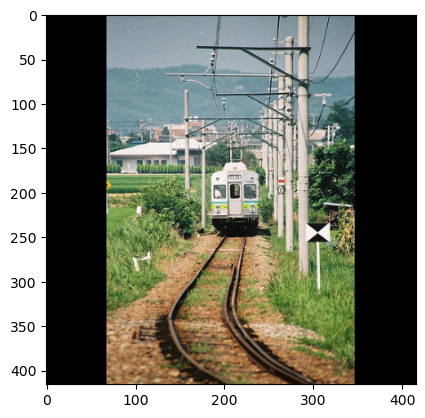

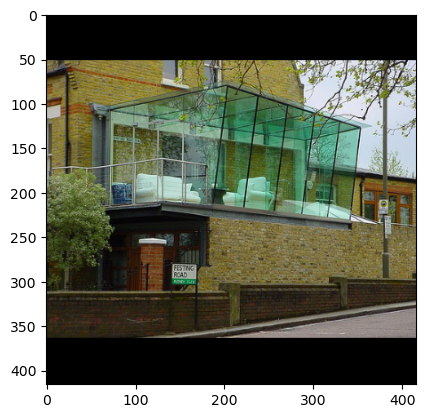

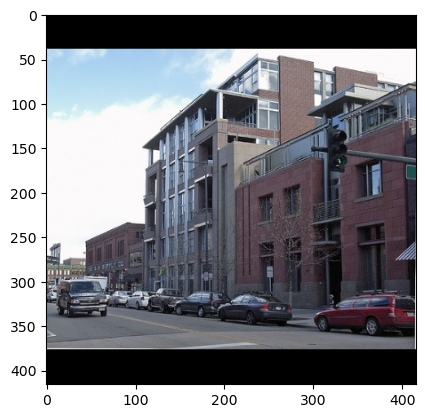

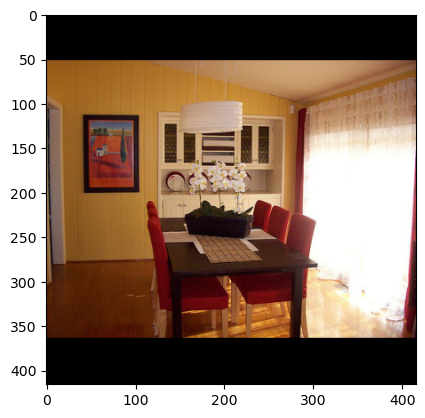

100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:58<00:00,  5.32it/s]


Class accuracy is: 2.369077%
No obj accuracy is: 100.000000%
Obj accuracy is: 0.000000%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [02:42<00:00,  1.91it/s]

MAP: 0.0


In [13]:
from YOLO_V3.PL_main import calc_MAP
test_loader = yolo_datamodule.test_dataloader()
calc_MAP(yolo_model.to(config.DEVICE), test_loader, config, scaled_anchors)

In [ ]:
yolo_model_trained = yolo_model

**Load trained model**

In [65]:
model_path = "/content/gdrive/MyDrive/trained_models/YOLOv3/75_mosaic_checkpoint_epoch_39_batch_size_16.ckpt"

In [66]:
from torch.optim.lr_scheduler import OneCycleLR
# Define model parameters
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)
# Define Model
yolo_model_trained = LitYOLOv3.load_from_checkpoint(model_path)


**Fetch data loaders**

In [67]:

train_data_loader = yolo_dm.train_dataloader()
test_data_loader = yolo_dm.test_dataloader()


**Define the targets for GradCAM**

In [68]:
import torchvision
from dl_hub.YOLO_V3.yolo_v3_utils.utils import non_max_suppression, plot_image
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image
import cv2
import numpy as np

# This will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(config.PASCAL_CLASSES), 3))

class YOLOv3Target:
    pass

def get_box_coords(box, im):
    height, width, _ = im.shape
    upper_left_x = int((box[0] - box[2] / 2)*width)
    upper_left_y = int((box[1] - box[3] / 2)*height)
    lower_right_x = upper_left_x + int(box[2]*width)
    lower_right_y = upper_left_y + int(box[3]*height)
    return [upper_left_x, upper_left_y, lower_right_x, lower_right_y]


def draw_boxes(boxes, labels, classes, confidences, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, f"{classes[i]}({confidences[i]:0.2f})", (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image


def get_eigen_cam_image_overlay(boxes,
                                image_float_np,
                                grayscale_cam,
                                renormalize=False,
                                image_weight=0.7):
    """
    Show the CAM image along with the detected bounding boxes.
    If renormalize is set to true,Normalize the CAM to be in the range [0, 1]
    inside every bounding boxes, and zero outside of the bounding boxes.
    """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    images = []
    box_coords = []
    if renormalize:
        for box in boxes:
            [x1,y1,x2,y2] = get_box_coords(box[2:],image_float_np)
            img = renormalized_cam * 0
            img[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())
            images.append(img)
            box_coords.append([x1,y1,x2,y2])
            renormalized_cam = np.max(np.float32(images), axis = 0)
            renormalized_cam = scale_cam_image(renormalized_cam)
            eigen_cam_image = show_cam_on_image(image_float_np,
                                                renormalized_cam,
                                                use_rgb=True,
                                                image_weight=image_weight)
    else:
        eigen_cam_image =  show_cam_on_image(image_float_np,
                                             grayscale_cam,
                                             use_rgb=True,
                                             image_weight=image_weight)
    return eigen_cam_image

def export_image_with_bounding_box(image, boxes,labels, classes, confidences):
    box_coords = []
    for box in boxes:
        [x1,y1,x2,y2] = get_box_coords(box[2:],image)
        box_coords.append([x1,y1,x2,y2])
    pil_img = Image.fromarray(draw_boxes(box_coords,labels,classes,confidences,image))
    return pil_img


In [69]:
import numpy as np
import matplotlib.pyplot as plt


def get_labels(boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = config.COCO_LABELS if config.DATASET=='COCO' else config.PASCAL_CLASSES
    all_class_names = []
    all_class_labels = []
    all_confidences = []
    for box in boxes:
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        class_name = class_labels[int(class_pred)]
        all_class_names.append(class_name)
        class_label = int(class_pred)
        all_class_labels.append(class_label)
        all_confidences.append(box[1])
    return all_class_names, all_class_labels, all_confidences


def predict(model, loader, anchors, device, thresh=0.6, iou_thresh=0.5):
    model.eval()
    x, y = next(iter(loader))
    num_images = x.shape[0]
    x = x.to(device)
    global_height, global_width = x.shape[-2:]
    boxes_list = []
    classes_list = []
    labels_list = []
    confidences_list = []
    with torch.no_grad():
        out = model(x)
        bboxes = [[] for _ in range(x.shape[0])]
        for i in range(3):
            batch_size, A, S, _, _ = out[i].shape
            anchor = anchors[i]
            boxes_scale_i = cells_to_bboxes(
                out[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box
    for i in range(num_images):
        nms_boxes = non_max_suppression(
            bboxes[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
        )
        classes, labels, confidences = get_labels(nms_boxes)
        boxes_list.append(nms_boxes)
        classes_list.append(classes)
        labels_list.append(labels)
        confidences_list.append(confidences)
    x_np_float_array = np.asarray(x.cpu())
    return x, x_np_float_array, boxes_list, classes_list, labels_list, confidences_list


In [70]:
# Target layer for lowest scale prediction: yolo_model_trained.model.layers[-1].pred[0]
# Target layer for 2nd lowest scale prediction: yolo_model_trained.model.layers[22].pred[0]
# Target layer for highest scale prediction: yolo_model_trained.model.layers[15].pred[0]
target_layers = [yolo_model_trained.model.layers[15].pred[0],
                 yolo_model_trained.model.layers[22].pred[0],
                 yolo_model_trained.model.layers[-1].pred[0]]
targets = [YOLOv3Target()]
cam = EigenCAM(yolo_model_trained,
               target_layers,
               use_cuda=torch.cuda.is_available(),
               reshape_transform=None)
input_tensor, image_float_np, boxes, classes, labels, confidences = predict(
    yolo_model_trained,
    test_data_loader,
    scaled_anchors,
    device = config.DEVICE,
    thresh=0.6,
    iou_thresh=0.3)
grayscale_cam = cam(input_tensor, targets=targets)


In [41]:
confidences

[0.7400769591331482]

In [64]:
renormalize_cam = False
image_weight = 0.7
#img_cv = cv2.cvtColor(np.uint8(image_float_np*255), cv2.COLOR_BGR2RGB)
#image_float_np[cnt].squeeze().transpose((1,2,0))
for cnt in range(input_tensor.shape[0]):
    composite_img = get_eigen_cam_image_overlay(boxes[cnt],
                                      image_float_np[cnt].squeeze().transpose((1,2,0)),
                                      grayscale_cam[cnt].squeeze().T,
                                      renormalize=renormalize_cam,
                                      image_weight=image_weight)
    composite_img_w_bb = export_image_with_bounding_box(composite_img,
                                                        boxes[cnt],
                                                        labels[cnt],
                                                        classes[cnt],
                                                        confidences[cnt])
    composite_img_w_bb.save(f'test3_{cnt}.png')


In [ ]:
import torchinfo

def model_summary(model, input_size):
    torchinfo.summary(model,
                      input_size = input_size,
                      batch_dim=0,
                      col_names=("kernel_size",
                                 "input_size",
                                 "output_size",
                                 "num_params",
                                 "mult_adds"),
                       verbose=1,)

model_summary(yolo_model_trained, (3, 416, 416))

Layer (type:depth-idx)                                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
LitYOLOv3                                               --                        [1, 3, 416, 416]          [1, 3, 13, 13, 25]        --                        --
├─YOLOv3: 1-1                                           --                        --                        --                        --                        --
│    └─ModuleList: 2-1                                  --                        --                        --                        --                        --
│    │    └─CNNBlock: 3-1                               --                        [1, 3, 416, 416]          [1, 32, 416, 416]         928                       149,520,448
│    │    └─CNNBlock: 3-2                               --                        [1, 32, 416, 416]         [1, 64, 208, 208]         18,560                    797,442,1